In [1]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [2]:
lena_gray = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)

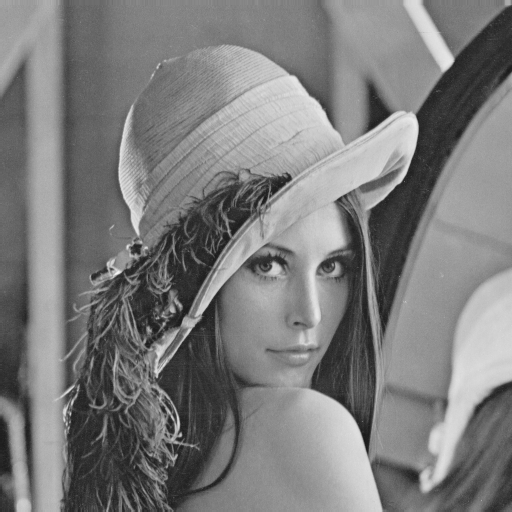

In [3]:
cv2_imshow(lena_gray)

In [62]:
N = lena_gray.shape[0]*lena_gray.shape[1]
N

262144

In [64]:
mu_s = np.sum(lena_gray)/N
mu_s

124.04678344726562

In [65]:
VS = np.sum((lena_gray-mu_s)**2)/N
VS

2290.1517724907026

In [40]:
noise_img_dict = {}
for method in ["g", "sp"]:
  for level in range(2):
    if method == "g":
      amplitude = 10 if level==0 else 30
      noise = amplitude * np.random.normal(0,1,lena_gray.shape)
      noise_img = np.around(lena_gray + noise)
      noise_img[noise_img>255] = 255
      noise_img[noise_img<0] = 0
      noise_img_dict["Gnoise"+str(amplitude)] = np.uint8(noise_img)
    else:
      prob = 0.05 if level==0 else 0.1
      noise_value = np.random.uniform(0,1,lena_gray.shape)
      noise_img = lena_gray.copy()
      noise_img[noise_value>=(1-prob)] = 255
      noise_img[noise_value<=prob] = 0
      noise_img_dict["SPnoise"+str(prob).replace(".", "")+("0" if level==1 else "")] = noise_img

In [41]:
noise_img_dict

{'Gnoise10': array([[162, 166, 155, ..., 168, 145, 136],
        [159, 150, 164, ..., 179, 134, 120],
        [168, 176, 154, ..., 148, 166, 119],
        ...,
        [ 42,  37,  61, ..., 105, 111,  98],
        [  6,  50,  69, ..., 105, 109,  99],
        [ 49,  32,  50, ...,  93, 121, 120]], dtype=uint8),
 'Gnoise30': array([[166, 214, 145, ..., 172, 153, 109],
        [169, 154, 192, ..., 141, 162, 104],
        [121, 123, 168, ..., 184, 140, 117],
        ...,
        [ 45,  73,  60, ..., 100,  74,  78],
        [ 28,   8,  89, ...,  99, 174, 123],
        [ 38,  36,  22, ..., 100,  96,  61]], dtype=uint8),
 'SPnoise005': array([[  0, 162, 162, ..., 170, 155, 128],
        [162, 162, 162, ..., 170, 155,   0],
        [162, 162, 162, ..., 170, 155, 128],
        ...,
        [ 43, 255,  50, ..., 104, 100,   0],
        [ 44,  44,  55, ..., 104,   0, 108],
        [ 44,  44,  55, ..., 104, 105, 108]], dtype=uint8),
 'SPnoise010': array([[162, 162, 162, ..., 255, 155, 128],
        [

In [69]:
for NIname, img in noise_img_dict.items():
  mu_n = np.sum(img-lena_gray)/N
  VN = np.sum((img-lena_gray-mu_n)**2)/N
  SNR = 20*np.log10(np.sqrt(VS)/np.sqrt(VN))
  print(NIname+", SNR="+str(SNR))

Gnoise10, SNR=-7.98880838794754
[[162 166 155 ... 168 145 136]
 [159 150 164 ... 179 134 120]
 [168 176 154 ... 148 166 119]
 ...
 [ 42  37  61 ... 105 111  98]
 [  6  50  69 ... 105 109  99]
 [ 49  32  50 ...  93 121 120]]
Gnoise30, SNR=-6.888122678493178
[[166 214 145 ... 172 153 109]
 [169 154 192 ... 141 162 104]
 [121 123 168 ... 184 140 117]
 ...
 [ 45  73  60 ... 100  74  78]
 [ 28   8  89 ...  99 174 123]
 [ 38  36  22 ... 100  96  61]]
SPnoise005, SNR=1.0417351445135954
[[  0 162 162 ... 170 155 128]
 [162 162 162 ... 170 155   0]
 [162 162 162 ... 170 155 128]
 ...
 [ 43 255  50 ... 104 100   0]
 [ 44  44  55 ... 104   0 108]
 [ 44  44  55 ... 104 105 108]]
SPnoise010, SNR=-1.4598339287454578
[[162 162 162 ... 255 155 128]
 [162 162   0 ... 170 155 128]
 [162 162 162 ... 170 155 128]
 ...
 [ 43  43  50 ... 104 100  98]
 [ 44  44  55 ... 104 105 108]
 [ 44  44  55 ... 104 105 108]]


In [55]:
def BoxFilter(img, size):
  bo = 1 if size == 3 else 2
  border_img = cv2.copyMakeBorder(img,bo,bo,bo,bo,cv2.BORDER_REPLICATE)
  m,n = lena_gray.shape
  total = np.zeros((m,n))
  for r in range(size):
    for c in range(size):
      total += border_img[r:r+m,c:c+n]
  result = total/(size**2)
  return np.around(result)

In [56]:
def MedianFilter(img, size):
  bo = 1 if size == 3 else 2
  border_img = cv2.copyMakeBorder(img,bo,bo,bo,bo,cv2.BORDER_REPLICATE)
  m,n = lena_gray.shape
  total = np.zeros((m,n,size**2))
  i = 0
  for r in range(size):
    for c in range(size):
      total[:,:,i] = border_img[r:r+m,c:c+n]
      i+=1
  total_sort = np.sort(total,2)
  result = total_sort[:,:,size**2//2]
  return result

In [57]:
def Dilation(img):
  border_img = cv2.copyMakeBorder(img,2,2,2,2,cv2.BORDER_REPLICATE)
  m,n = img.shape
  result = np.zeros(img.shape)
  for i in range(5):
    for j in range(5):
      if i in [0,4] and j in [0,4]:
        continue
      result = np.maximum(result,border_img[i:i+m,j:j+n])
  return result

In [58]:
def Erosion(img):
  border_img = cv2.copyMakeBorder(img,2,2,2,2,cv2.BORDER_REPLICATE)
  m,n = img.shape
  result = np.ones(img.shape)*255
  for i in range(5):
    for j in range(5):
      if i in [0,4] and j in [0,4]:
        continue
      result = np.minimum(result,border_img[i:i+m,j:j+n])
  return result

In [59]:
def Opening(img):
  return Dilation(Erosion(img))

In [60]:
def Closing(img):
  return Erosion(Dilation(img))

In [ ]:
for NIname, img in noise_img_dict.items():
  for method in ["Box", "Median", "OandC"]:
    for case in range(2):
      if method in ["Box", "Median"]:
        size = 3 if case == 0 else 5
        result = BoxFilter(img, size) if method=="Box" else MedianFilter(img, size)
        Rname = NIname+"_"+method+str(size)+"x"+str(size)
      else:
        methodName = "OthenC" if case==0 else "CthenO"
        result = Closing(Opening(img)) if case==0 else Opening(Closing(img))
        Rname = NIname+"_"+methodName
      mu_n = np.sum(result-lena_gray)/N
      VN = np.sum((result-lena_gray-mu_n)**2)/N
      SNR = 20*np.log10(np.sqrt(VS)/np.sqrt(VN))
      print(Rname+", SNR="+str(SNR))
      print(result)

In [71]:
%%writefile /content/drive/MyDrive/CVHW/HW8.py
import cv2
import numpy as np

def BoxFilter(img, size):
  bo = 1 if size == 3 else 2
  border_img = cv2.copyMakeBorder(img,bo,bo,bo,bo,cv2.BORDER_REPLICATE)
  m,n = lena_gray.shape
  total = np.zeros((m,n))
  for r in range(size):
    for c in range(size):
      total += border_img[r:r+m,c:c+n]
  result = total/(size**2)
  return np.around(result)

def MedianFilter(img, size):
  bo = 1 if size == 3 else 2
  border_img = cv2.copyMakeBorder(img,bo,bo,bo,bo,cv2.BORDER_REPLICATE)
  m,n = lena_gray.shape
  total = np.zeros((m,n,size**2))
  i = 0
  for r in range(size):
    for c in range(size):
      total[:,:,i] = border_img[r:r+m,c:c+n]
      i+=1
  total_sort = np.sort(total,2)
  result = total_sort[:,:,size**2//2]
  return result

def Dilation(img):
  border_img = cv2.copyMakeBorder(img,2,2,2,2,cv2.BORDER_REPLICATE)
  m,n = img.shape
  result = np.zeros(img.shape)
  for i in range(5):
    for j in range(5):
      if i in [0,4] and j in [0,4]:
        continue
      result = np.maximum(result,border_img[i:i+m,j:j+n])
  return result

def Erosion(img):
  border_img = cv2.copyMakeBorder(img,2,2,2,2,cv2.BORDER_REPLICATE)
  m,n = img.shape
  result = np.ones(img.shape)*255
  for i in range(5):
    for j in range(5):
      if i in [0,4] and j in [0,4]:
        continue
      result = np.minimum(result,border_img[i:i+m,j:j+n])
  return result

def Opening(img):
  return Dilation(Erosion(img))

def Closing(img):
  return Erosion(Dilation(img))

lena_gray = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
N = lena_gray.shape[0]*lena_gray.shape[1]
mu_s = np.sum(lena_gray)/N
VS = np.sum((lena_gray-mu_s)**2)/N

noise_img_dict = {}
for method in ["g", "sp"]:
  for level in range(2):
    if method == "g":
      amplitude = 10 if level==0 else 30
      noise = amplitude * np.random.normal(0,1,lena_gray.shape)
      noise_img = np.around(lena_gray + noise)
      noise_img[noise_img>255] = 255
      noise_img[noise_img<0] = 0
      noise_img_dict["Gnoise"+str(amplitude)] = np.uint8(noise_img)
    else:
      prob = 0.05 if level==0 else 0.1
      noise_value = np.random.uniform(0,1,lena_gray.shape)
      noise_img = lena_gray.copy()
      noise_img[noise_value>=(1-prob)] = 255
      noise_img[noise_value<=prob] = 0
      noise_img_dict["SPnoise"+str(prob).replace(".", "")+("0" if level==1 else "")] = noise_img

for NIname, img in noise_img_dict.items():
  mu_n = np.sum(img-lena_gray)/N
  VN = np.sum((img-lena_gray-mu_n)**2)/N
  SNR = 20*np.log10(np.sqrt(VS)/np.sqrt(VN))
  print(NIname+", SNR="+str(SNR))
  cv2.imwrite(NIname+".bmp", img)

for NIname, img in noise_img_dict.items():
  for method in ["Box", "Median", "OandC"]:
    for case in range(2):
      if method in ["Box", "Median"]:
        size = 3 if case == 0 else 5
        result = BoxFilter(img, size) if method=="Box" else MedianFilter(img, size)
        Rname = NIname+"_"+method+str(size)+"x"+str(size)
      else:
        methodName = "OthenC" if case==0 else "CthenO"
        result = Closing(Opening(img)) if case==0 else Opening(Closing(img))
        Rname = NIname+"_"+methodName
      mu_n = np.sum(result-lena_gray)/N
      VN = np.sum((result-lena_gray-mu_n)**2)/N
      SNR = 20*np.log10(np.sqrt(VS)/np.sqrt(VN))
      print(Rname+", SNR="+str(SNR))
      cv2.imwrite(Rname+".bmp",result)

Writing /content/drive/MyDrive/CVHW/HW8.py
